In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to Pistachio images
dataset_path = '/content/drive/MyDrive/Machine Learning Lab/ML Project/Pistachio_Image_Dataset'
img_size = (224, 224)
batch_size = 32
seed = 42

In [ ]:
# Load full dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True  # Shuffle before splitting
)

Found 2148 files belonging to 2 classes.


In [ ]:
# Split manually: 80% train, 20% test
dataset_size = len(full_ds)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
])

In [ ]:
# Apply augmentation
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

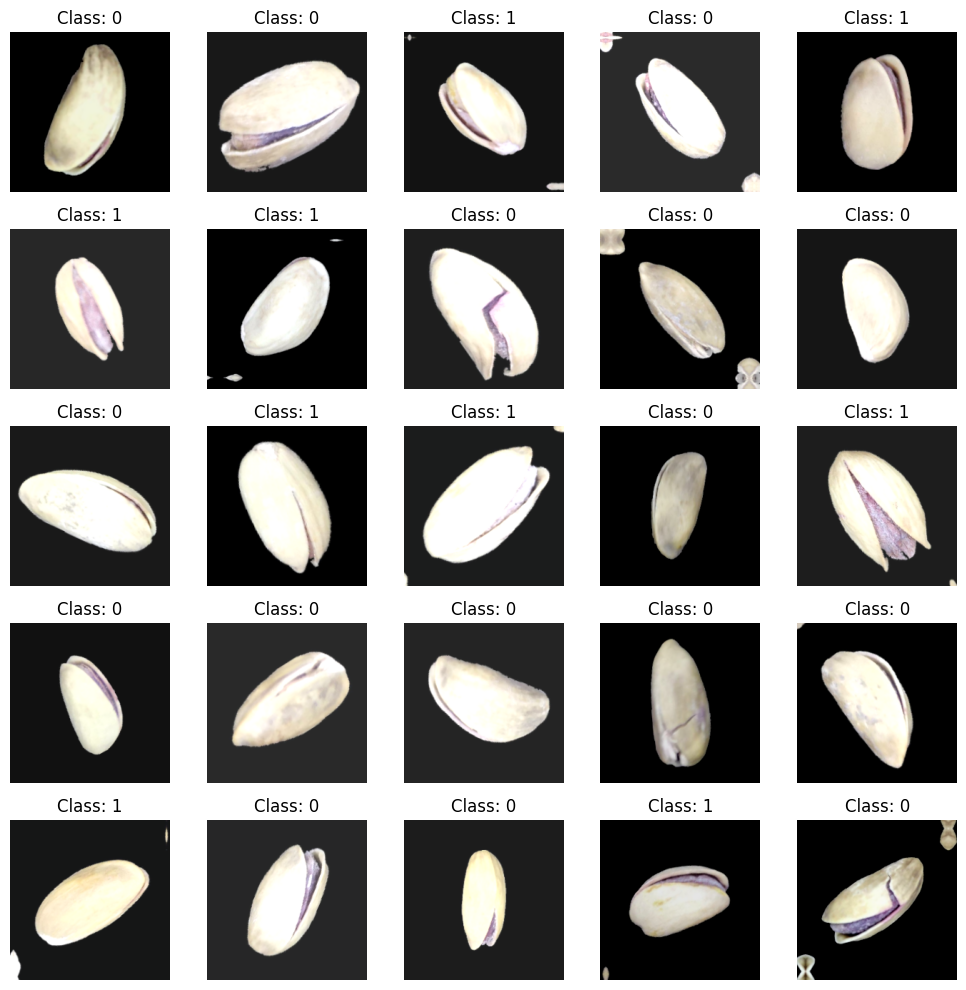

In [ ]:
# Show Images

import matplotlib.pyplot as plt

# Take a single batch of images from the augmented training dataset
image_batch, label_batch = next(iter(augmented_train_ds))

# Number of images to display (25 in a 5x5 grid)
num_images_to_display = 25

# Create a 5x5 grid for the images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the images in the batch
for i in range(num_images_to_display):
  ax = axes[i // 5, i % 5]  # Get the current subplot
  ax.imshow(image_batch[i].numpy().astype("uint8"))  # Display the image
  ax.set_title(f"Class: {label_batch[i].numpy()}")  # Set the class label as the title
  ax.axis("off")  # Turn off axes

plt.tight_layout()
plt.show()


In [ ]:
# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Build Custom CNN model
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3), name='input_layer'),
    Rescaling(1./255),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2,2)),
    MaxPooling2D((3,3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])

# Compile
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 451,410 (1.72 MB)

 Trainable params: 451,410 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
history = model.fit(augmented_train_ds, epochs=5)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5908 - loss: 0.6693
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7367 - loss: 0.5527
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7453 - loss: 0.5177
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7714 - loss: 0.4757
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7519 - loss: 0.4864


In [ ]:
# Test
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7680 - loss: 0.4984
Test Accuracy: 0.76


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1232s 23s/step - accuracy: 0.6132 - loss: 16.8912 - val_accuracy: 0.8929 - val_loss: 0.2852
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1173s 22s/step - accuracy: 0.8479 - loss: 0.3726 - val_accuracy: 0.9310 - val_loss: 0.1818
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1167s 22s/step - accuracy: 0.8565 - loss: 0.3477 - val_accuracy: 0.9548 - val_loss: 0.1515
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1255s 22s/step - accuracy: 0.9050 - loss: 0.2687 - val_accuracy: 0.9429 - val_loss: 0.1875
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 1168s 22s/step - accuracy: 0.8968 - loss: 0.2589 - val_accuracy: 0.9476 - val_loss: 0.1668
14/14 ━━━━━━━━━━━━━━━━━━━━ 229s 16s/step - accuracy: 0.9523 - loss: 0.1533
Test Accuracy: 0.95


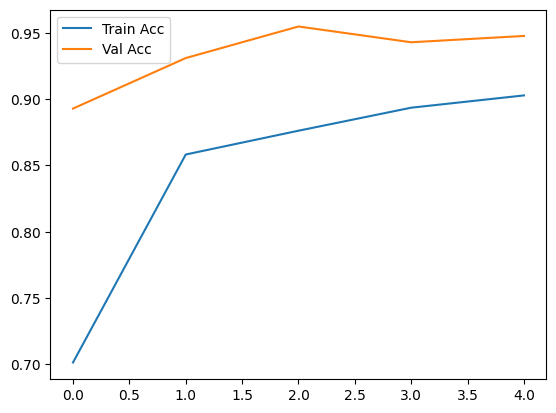

In [ ]:
# Transfer Learning

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load pre-trained VGG16 model (excluding top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(augmented_train_ds, epochs=5, validation_data=test_ds)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()